In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
from datetime import datetime, timedelta

Solar Generation Analysis
----------------------------------------
Found 405 actual generation files

Plotting sample generation profiles...
Saved generation profiles to generation_profiles.png
Saved normalized profiles to normalized_profiles.png

Comparing forecast with actual generation...
Error creating forecast comparison: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

Analyzing daily variability...


/var/folders/qd/1pjv967d1ylfl4mzr8flbvb00000gn/T/ipykernel_1747/3609069623.py:212: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  actual_hourly = actual_df['Power(MW)'].resample('H').mean()



Analysis complete.


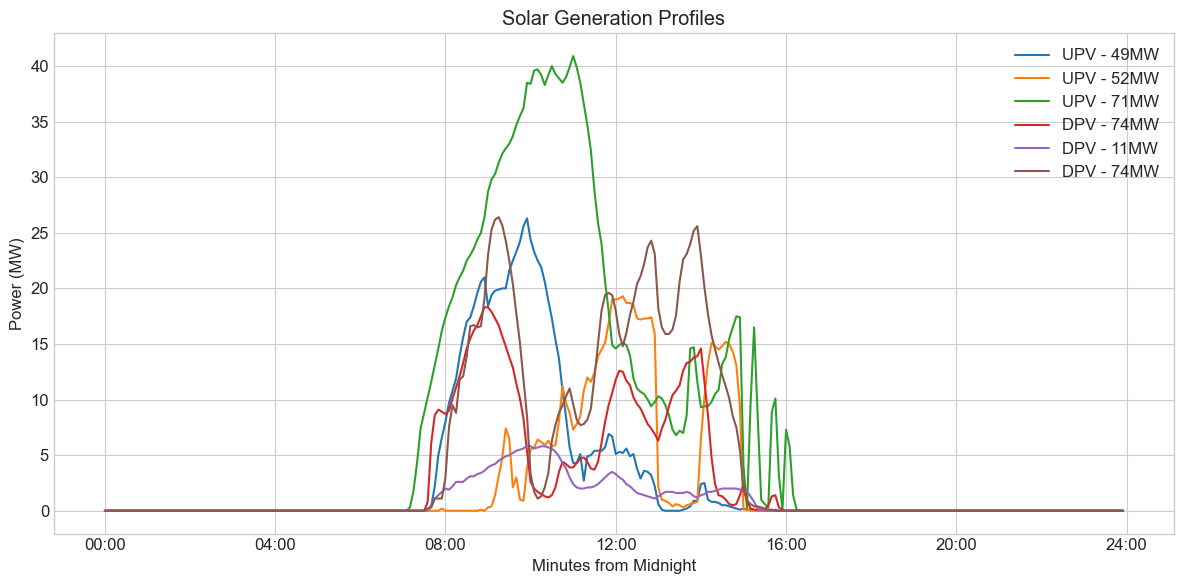

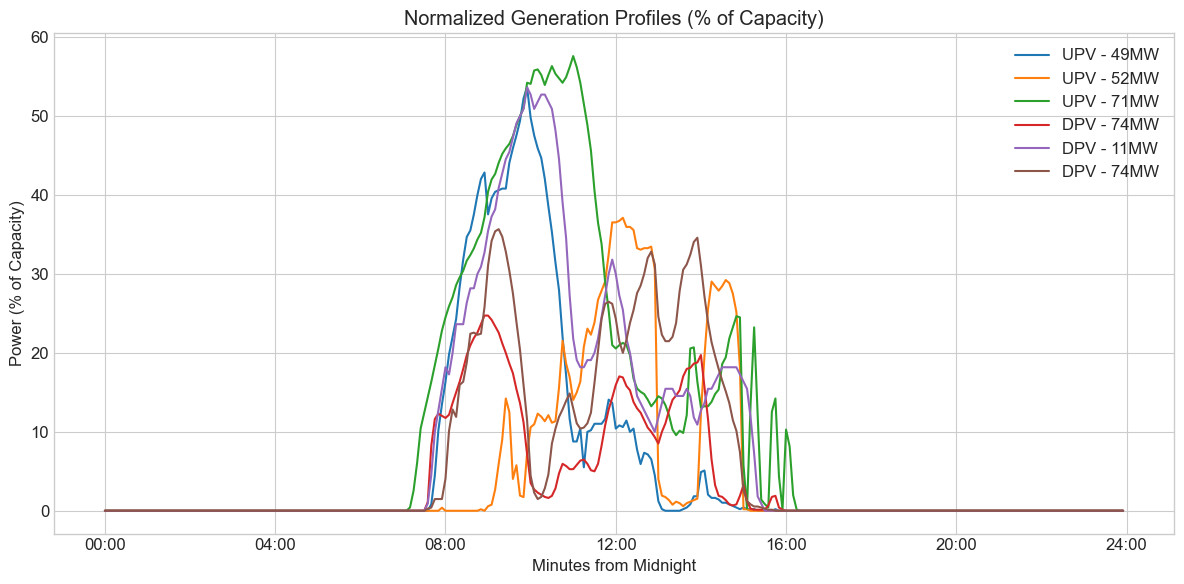

In [14]:
def analyze_solar_data(data_dir="./data"):
    # Find actual generation files
    actual_files = glob.glob(os.path.join(data_dir, "Actual_*.csv"))
    
    if not actual_files:
        print(f"No generation data files found in {data_dir}")
        return
    
    print(f"Found {len(actual_files)} actual generation files")
    
    # Extract capacity information from filenames
    capacities = {}
    pv_types = {}
    
    for file in actual_files:
        basename = os.path.basename(file)
        try:
            # Example: Actual_32.55_-117.05_2006_DPV_13MW_5_Min.csv
            parts = basename.split('_')
            pv_type = parts[4]  # DPV or UPV
            capacity = int(parts[5].replace('MW', ''))  # Extract MW value
            
            capacities[file] = capacity
            pv_types[file] = pv_type
        except:
            print(f"Error parsing filename: {basename}")
    
    # 1. Directly plot a few random files
    print("\nPlotting sample generation profiles...")
    upv_files = [f for f in actual_files if pv_types.get(f) == 'UPV']
    dpv_files = [f for f in actual_files if pv_types.get(f) == 'DPV']
    
    # Select a few files for each type
    sample_upv = upv_files[:3] if len(upv_files) >= 3 else upv_files
    sample_dpv = dpv_files[:3] if len(dpv_files) >= 3 else dpv_files
    
    sample_files = sample_upv + sample_dpv
    
    # 1. Plot raw generation profiles
    plt.figure(figsize=(12, 6))
    plotted_any = False
    
    for file in sample_files:
        try:
            # Get file metadata
            pv_type = pv_types.get(file, 'Unknown')
            capacity = capacities.get(file, 0)
            
            # Read data
            df = pd.read_csv(file)
            
            # Check data columns
            if 'Power(MW)' not in df.columns:
                continue
                
            # Convert time if available
            if 'Time' in df.columns:
                df['Time'] = pd.to_datetime(df['Time'])
                
            # Get the first 288 rows (full day for 5-minute data)
            if len(df) >= 288:
                data = df.iloc[:288]
                
                # Create time index (minutes from midnight)
                if 'Time' in df.columns:
                    # Use actual timestamps
                    minutes = [(t.hour * 60 + t.minute) for t in data['Time']]
                else:
                    # Create synthetic timestamps (5 minute intervals)
                    minutes = [i * 5 for i in range(len(data))]
                
                # Plot generation profile
                label = f"{pv_type} - {capacity}MW"
                plt.plot(minutes, data['Power(MW)'], label=label)
                plotted_any = True
        except Exception as e:
            print(f"Error plotting {os.path.basename(file)}: {e}")
    
    if plotted_any:
        plt.title("Solar Generation Profiles")
        plt.xlabel("Minutes from Midnight")
        plt.ylabel("Power (MW)")
        plt.xticks([0, 240, 480, 720, 960, 1200, 1440], 
                ['00:00', '04:00', '08:00', '12:00', '16:00', '20:00', '24:00'])
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("generation_profiles.png")
        print("Saved generation profiles to generation_profiles.png")
    else:
        print("Failed to plot any generation profiles")
    
    # 2. Normalized profiles
    plt.figure(figsize=(12, 6))
    plotted_any = False
    
    for file in sample_files:
        try:
            # Get file metadata
            pv_type = pv_types.get(file, 'Unknown')
            capacity = capacities.get(file, 0)
            
            if capacity <= 0:
                continue
                
            # Read data
            df = pd.read_csv(file)
            
            # Check data columns
            if 'Power(MW)' not in df.columns:
                continue
                
            # Convert time if available
            if 'Time' in df.columns:
                df['Time'] = pd.to_datetime(df['Time'])
                
            # Get the first 288 rows (full day for 5-minute data)
            if len(df) >= 288:
                data = df.iloc[:288]
                
                # Create time index (minutes from midnight)
                if 'Time' in df.columns:
                    # Use actual timestamps
                    minutes = [(t.hour * 60 + t.minute) for t in data['Time']]
                else:
                    # Create synthetic timestamps (5 minute intervals)
                    minutes = [i * 5 for i in range(len(data))]
                
                # Normalize by capacity
                norm_power = (data['Power(MW)'] / capacity) * 100
                
                # Plot normalized profile
                label = f"{pv_type} - {capacity}MW"
                plt.plot(minutes, norm_power, label=label)
                plotted_any = True
        except Exception as e:
            print(f"Error plotting normalized data for {os.path.basename(file)}: {e}")
    
    if plotted_any:
        plt.title("Normalized Generation Profiles (% of Capacity)")
        plt.xlabel("Minutes from Midnight")
        plt.ylabel("Power (% of Capacity)")
        plt.xticks([0, 240, 480, 720, 960, 1200, 1440], 
                ['00:00', '04:00', '08:00', '12:00', '16:00', '20:00', '24:00'])
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("normalized_profiles.png")
        print("Saved normalized profiles to normalized_profiles.png")
    else:
        print("Failed to plot any normalized profiles")
    
    # 3. Forecast vs actual
    print("\nComparing forecast with actual generation...")
    da_files = glob.glob(os.path.join(data_dir, "DA_*.csv"))
    ha4_files = glob.glob(os.path.join(data_dir, "HA4_*.csv"))
    
    # Find a matching set
    sample_actual = actual_files[0]
    basename = os.path.basename(sample_actual)
    parts = basename.split('_')
    
    # Create matching pattern for forecasts (e.g., if Actual_32.55_-117.05_2006_DPV_13MW_5_Min.csv,
    # look for DA_32.55_-117.05_2006_DPV_13MW_60_Min.csv)
    pattern = '_'.join(parts[1:6])  # lat_lon_year_type_capacity
    
    sample_da = [f for f in da_files if pattern in os.path.basename(f)]
    sample_ha4 = [f for f in ha4_files if pattern in os.path.basename(f)]
    
    if sample_da and sample_ha4:
        try:
            # Read data
            actual_df = pd.read_csv(sample_actual)
            da_df = pd.read_csv(sample_da[0])
            ha4_df = pd.read_csv(sample_ha4[0])
            
            # Extract capacity from filename
            capacity = capacities.get(sample_actual, 0)
            pv_type = pv_types.get(sample_actual, 'Unknown')
            
            # Convert timestamps
            if 'Time' in actual_df.columns:
                actual_df['Time'] = pd.to_datetime(actual_df['Time'])
                actual_df.set_index('Time', inplace=True)
            
            if 'Time' in da_df.columns:
                da_df['Time'] = pd.to_datetime(da_df['Time'])
                da_df.set_index('Time', inplace=True)
                
            if 'Time' in ha4_df.columns:
                ha4_df['Time'] = pd.to_datetime(ha4_df['Time'])
                ha4_df.set_index('Time', inplace=True)
            
            # Resample actual data to hourly to match forecasts
            if 'Power(MW)' in actual_df.columns:
                actual_hourly = actual_df['Power(MW)'].resample('H').mean()
                
                # Find common date range
                common_dates = sorted(list(set(actual_hourly.index) & 
                                      set(da_df.index) & 
                                      set(ha4_df.index)))
                
                if common_dates:
                    # Take a 3-day sample if available
                    forecast_days = min(3, len(common_dates) // 24)
                    sample_dates = common_dates[:24 * forecast_days]
                    
                    # Create DataFrame with aligned data
                    plot_df = pd.DataFrame({
                        'Actual': actual_hourly.loc[sample_dates],
                        'Day-Ahead': da_df.loc[sample_dates, 'Power(MW)'],
                        '4-Hour-Ahead': ha4_df.loc[sample_dates, 'Power(MW)']
                    })
                    
                    # Plot comparison
                    plt.figure(figsize=(14, 7))
                    plt.plot(plot_df.index, plot_df['Actual'], 'b-', label='Actual', linewidth=2)
                    plt.plot(plot_df.index, plot_df['Day-Ahead'], 'r--', label='Day-Ahead Forecast', linewidth=2)
                    plt.plot(plot_df.index, plot_df['4-Hour-Ahead'], 'g-.', label='4-Hour-Ahead Forecast', linewidth=2)
                    
                    plt.title(f"Solar Generation: Actual vs Forecasts ({capacity}MW {pv_type})")
                    plt.xlabel("Date")
                    plt.ylabel("Power (MW)")
                    plt.legend()
                    plt.grid(True)
                    plt.tight_layout()
                    plt.savefig("forecast_comparison.png")
                    print("Saved forecast comparison to forecast_comparison.png")
                    
                    # Calculate and plot errors
                    plt.figure(figsize=(14, 7))
                    plt.plot(plot_df.index, plot_df['Day-Ahead'] - plot_df['Actual'], 
                            'r-', label='Day-Ahead Error', linewidth=2)
                    plt.plot(plot_df.index, plot_df['4-Hour-Ahead'] - plot_df['Actual'], 
                            'g-', label='4-Hour-Ahead Error', linewidth=2)
                    
                    plt.title(f"Forecast Errors ({capacity}MW {pv_type})")
                    plt.xlabel("Date")
                    plt.ylabel("Error (Forecast - Actual) in MW")
                    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
                    plt.legend()
                    plt.grid(True)
                    plt.tight_layout()
                    plt.savefig("forecast_errors.png")
                    print("Saved forecast errors to forecast_errors.png")
                    
        except Exception as e:
            print(f"Error creating forecast comparison: {e}")
    
    # 4. Daily variability
    print("\nAnalyzing daily variability...")
    
    # Try to find a file with multiple days of data
    for file in actual_files:
        try:
            df = pd.read_csv(file)
            
            if len(df) >= 576:  # At least 2 days of data (288 * 2)
                if 'Time' in df.columns:
                    # Convert to datetime
                    df['Time'] = pd.to_datetime(df['Time'])
                    
                    # Extract day from timestamp
                    df['Day'] = df['Time'].dt.date
                    
                    # Get unique days
                    unique_days = sorted(df['Day'].unique())
                    
                    if len(unique_days) >= 3:  # At least 3 days of data
                        capacity = capacities.get(file, 0)
                        pv_type = pv_types.get(file, 'Unknown')
                        
                        plt.figure(figsize=(12, 6))
                        
                        # Plot data for each day
                        for day in unique_days[:5]:  # Up to 5 days
                            day_data = df[df['Day'] == day]
                            
                            # Create minutes from midnight
                            day_data['Minutes'] = day_data['Time'].dt.hour * 60 + day_data['Time'].dt.minute
                            
                            # Sort by minutes
                            day_data = day_data.sort_values('Minutes')
                            
                            # Plot
                            plt.plot(day_data['Minutes'], day_data['Power(MW)'], 
                                    label=day.strftime('%Y-%m-%d'))
                        
                        plt.title(f"Day-to-Day Variability ({capacity}MW {pv_type})")
                        plt.xlabel("Minutes from Midnight")
                        plt.ylabel("Power (MW)")
                        plt.xticks([0, 240, 480, 720, 960, 1200, 1440], 
                                ['00:00', '04:00', '08:00', '12:00', '16:00', '20:00', '24:00'])
                        plt.legend()
                        plt.grid(True)
                        plt.tight_layout()
                        plt.savefig("daily_variability.png")
                        print("Saved daily variability to daily_variability.png")
                        
                        # Also create a normalized version
                        if capacity > 0:
                            plt.figure(figsize=(12, 6))
                            
                            # Plot normalized data for each day
                            for day in unique_days[:5]:  # Up to 5 days
                                day_data = df[df['Day'] == day]
                                
                                # Create minutes from midnight
                                day_data['Minutes'] = day_data['Time'].dt.hour * 60 + day_data['Time'].dt.minute
                                
                                # Sort by minutes
                                day_data = day_data.sort_values('Minutes')
                                
                                # Normalize
                                norm_power = (day_data['Power(MW)'] / capacity) * 100
                                
                                # Plot
                                plt.plot(day_data['Minutes'], norm_power, 
                                        label=day.strftime('%Y-%m-%d'))
                            
                            plt.title(f"Normalized Day-to-Day Variability ({capacity}MW {pv_type})")
                            plt.xlabel("Minutes from Midnight")
                            plt.ylabel("Power (% of Capacity)")
                            plt.xticks([0, 240, 480, 720, 960, 1200, 1440], 
                                    ['00:00', '04:00', '08:00', '12:00', '16:00', '20:00', '24:00'])
                            plt.legend()
                            plt.grid(True)
                            plt.tight_layout()
                            plt.savefig("normalized_daily_variability.png")
                            print("Saved normalized daily variability to normalized_daily_variability.png")
                        
                        break  # One set of plots is enough
        except Exception as e:
            continue
    
    print("\nAnalysis complete.")

if __name__ == "__main__":
    analyze_solar_data()